# Task detector v2

### The first version of this task had many issues:
- The model used for the task recognition was not well suited for this. We will now directly use the LSTM decoder to see what is the R2 when trying to predict velocity.
- We need to further explore how each perturbation affects performance of the model to understand the optimal range of perturbations.

### Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import math

# Imports DL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import copy


# Imports from other modules and packages in the project
sys.path.append('../')

from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
name = 'Chewie'
date = '1007'
fold = 0
target_variable = 'vel'

In [5]:
dtype = torch.float32

In [6]:
## Load pre-processed data
data_path = '../Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

## 1) Train RNN decoder on Baseline data to predict velocity

#### Get train-val-test split

In [7]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, 
                                        fold, target_variable= target_variable, 
                                        no_outliers = False, force_data = True,
                                        std = False)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0


In [8]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
#device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models/Models_Force'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [9]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

torch.manual_seed(42)

####### Define model
model_base =  Causal_Simple_RNN(num_features=num_features, 
                hidden_units= hidden_units, 
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)

#### Train model

In [10]:
train_losses, val_losses = \
    train_model(model_base, 
                xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_RNN, 
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

Epoch 000 Train 12.3228 Val 12.1863
Epoch 001 Train 11.0875 Val 11.1143
Epoch 002 Train 9.9910 Val 10.0244
Epoch 003 Train 9.0009 Val 9.0627
Epoch 004 Train 8.1100 Val 8.2161
Epoch 005 Train 7.2829 Val 7.4213
Epoch 006 Train 6.5193 Val 6.6435
Epoch 007 Train 5.7878 Val 5.9654
Epoch 008 Train 5.1355 Val 5.3305
Epoch 009 Train 4.5463 Val 4.8292
Epoch 010 Train 4.0024 Val 4.2998
Epoch 011 Train 3.4917 Val 3.9105
Epoch 012 Train 3.0768 Val 3.5447
Epoch 013 Train 2.7139 Val 3.2381
Epoch 014 Train 2.4244 Val 3.0232
Epoch 015 Train 2.1962 Val 2.8358
Epoch 016 Train 2.0073 Val 2.6721
Epoch 017 Train 1.8547 Val 2.5354
Epoch 018 Train 1.7276 Val 2.4077
Epoch 019 Train 1.6244 Val 2.3511
Epoch 020 Train 1.5429 Val 2.2406
Epoch 021 Train 1.4549 Val 2.1744
Epoch 022 Train 1.3846 Val 2.1034
Epoch 023 Train 1.3402 Val 2.0582
Epoch 024 Train 1.3013 Val 2.0185
Epoch 025 Train 1.2749 Val 1.9881
Epoch 026 Train 1.2457 Val 1.9918
Epoch 027 Train 1.2280 Val 1.9617
Epoch 028 Train 1.2084 Val 1.9661
Epoch 029

#### Evaluate model on baseline

In [11]:
y_hat, y_true,\
      train_score, v_score,\
          test_score = eval_model(xx_train_base,
                                   yy_train_base, 
                                   xx_val_base, 
                                   yy_val_base,
                                   xx_test_base, 
                                   yy_test_base, 
                                   model_base, 
                                   metric = 'r2')

Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 


## 2) Test different ratios and std for the simulated data

In [12]:
def remove_neurons(matrix, ratio):
    sim_data = matrix.copy()
    num_total_neurons = matrix.shape[1]
    num_removed = int((ratio/100)*num_total_neurons)
    idx_removed = random.sample(list(np.arange(0,num_total_neurons)), num_removed)
    for i in idx_removed:
        sim_data[:,i] = 0
    return sim_data

In [13]:
def shuffle_neurons(matrix, ratio):
    sim_data = matrix.copy()
    num_total_neurons = matrix.shape[1]
    num_neurons_to_shuffle = int((ratio/100)*num_total_neurons)
    ind_to_permute = random.sample(list(np.arange(0,num_total_neurons)), num_neurons_to_shuffle)
    ind_to_permute = np.sort(ind_to_permute)
    permuted_indices = np.random.permutation(ind_to_permute)
    for i, new_i in zip(ind_to_permute, permuted_indices):
        sim_data[:,i] = matrix[:,new_i]
    return sim_data

In [14]:
def modify_neurons(matrix, std_gain, std_offset):
    sim_data1 = matrix.copy()
    sim_data2 = matrix.copy()
    
    ### a) Multiplying each column by a random gain from gaussian dist.
    gains = np.random.normal(1, std_gain, size=sim_data1.shape[1])
    # Multiply each column of the matrix by the corresponding gain value
    sim_data1 = sim_data1 * gains[:, np.newaxis].T
    
    ### b) Random offsets
    offsets = np.random.normal(0, std_offset, size=sim_data2.shape[1])
    # Multiply each column of the matrix by the corresponding gain value
    sim_data2 = sim_data2 + offsets[:, np.newaxis].T

    return sim_data1, sim_data2

In [15]:
data_matrix = np.vstack(baseline_df['both_rates'])

In [16]:
ratios = np.arange(0,110,10)
v_scores_removed = []
v_scores_shuffled = []
for r in ratios:
    # First removed neurons
    sim_data = remove_neurons(data_matrix, r)
    baseline_df_sim = baseline_df.copy()
    baseline_df_sim['both_rates'] = sim_data.tolist()
    xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
      xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
          info_test_sim, list_mins_sim, \
            list_maxs_base= get_dataset(baseline_df_sim, 
                                        fold, 
                                        target_variable= target_variable,
                                        no_outliers = False, 
                                        force_data = True, 
                                        std = False)
    y_hat, y_true, train_score,\
       v_score, test_score = eval_model(xx_train_sim, 
                                        yy_train_sim, 
                                        xx_val_sim, 
                                        yy_val_sim,\
                                        xx_test_sim, 
                                        yy_test_sim,
                                        model_base, 
                                        metric = 'r2')
    v_scores_removed.append(v_score)

    # Second shuffled neurons
    sim_data = shuffle_neurons(data_matrix, r)
    baseline_df_sim = baseline_df.copy()
    baseline_df_sim['both_rates'] = sim_data.tolist()
    xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
      xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
          info_test_sim, list_mins_sim, \
            list_maxs_base= get_dataset(baseline_df_sim, 
                                        fold, 
                                        target_variable= target_variable,
                                        no_outliers = False, 
                                        force_data = True, 
                                        std = False)
    y_hat, y_true, train_score,\
       v_score, test_score = eval_model(xx_train_sim, 
                                        yy_train_sim, 
                                        xx_val_sim, 
                                        yy_val_sim,\
                                        xx_test_sim, 
                                        yy_test_sim,
                                        model_base, 
                                        metric = 'r2')
    v_scores_shuffled.append(v_score)
    
    

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.94 
Val R2: 0.89 
Test R2: 0.87 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.89 
Test R2: 0.86 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.76 
Val R2: 0.77 
Test R2: 0.71 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.90 
Val R2: 0.84 
Test R2: 0.80 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.67 
Val R2: 0.74 
Test R2: 0.64 
Train 

In [106]:
stds_gain = np.arange(0,1.4,0.1)
stds_offset = np.arange(0,41,3)
len(stds_gain)

14

In [107]:
len(stds_offset)

14

In [108]:
stds_gain = np.arange(0,1.4,0.1)
stds_offset = np.arange(0,41,3)

v_scores_gain = []
v_scores_offset = []
for s_g, s_o in zip(stds_gain,stds_offset) :
    # First removed neurons
    sim_data1, sim_data2 = modify_neurons(data_matrix, s_g, s_o)
    baseline_df_sim = baseline_df.copy()
    baseline_df_sim['both_rates'] = sim_data1.tolist()
    xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
      xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
          info_test_sim, list_mins_sim, \
            list_maxs_base= get_dataset(baseline_df_sim, 
                                        fold, 
                                        target_variable= target_variable,
                                        no_outliers = False, 
                                        force_data = True, 
                                        std = False)
    y_hat, y_true, train_score,\
       v_score, test_score = eval_model(xx_train_sim, 
                                        yy_train_sim, 
                                        xx_val_sim, 
                                        yy_val_sim,\
                                        xx_test_sim, 
                                        yy_test_sim,
                                        model_base, 
                                        metric = 'r2')
    v_scores_gain.append(v_score)

    # Second shuffled neurons
    baseline_df_sim = baseline_df.copy()
    baseline_df_sim['both_rates'] = sim_data2.tolist()
    xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
      xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
          info_test_sim, list_mins_sim, \
            list_maxs_base= get_dataset(baseline_df_sim, 
                                        fold, 
                                        target_variable= target_variable,
                                        no_outliers = False, 
                                        force_data = True, 
                                        std = False)
    y_hat, y_true, train_score,\
       v_score, test_score = eval_model(xx_train_sim, 
                                        yy_train_sim, 
                                        xx_val_sim, 
                                        yy_val_sim,\
                                        xx_test_sim, 
                                        yy_test_sim,
                                        model_base, 
                                        metric = 'r2')
    v_scores_offset.append(v_score)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.95 
Val R2: 0.90 
Test R2: 0.88 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.94 
Val R2: 0.88 
Test R2: 0.86 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.94 
Val R2: 0.89 
Test R2: 0.87 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.93 
Val R2: 0.85 
Test R2: 0.84 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.94 
Val R2: 0.87 
Test R2: 0.87 
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train R2: 0.92 
Val R2: 0.87 
Test R2: 0.86 
Train 

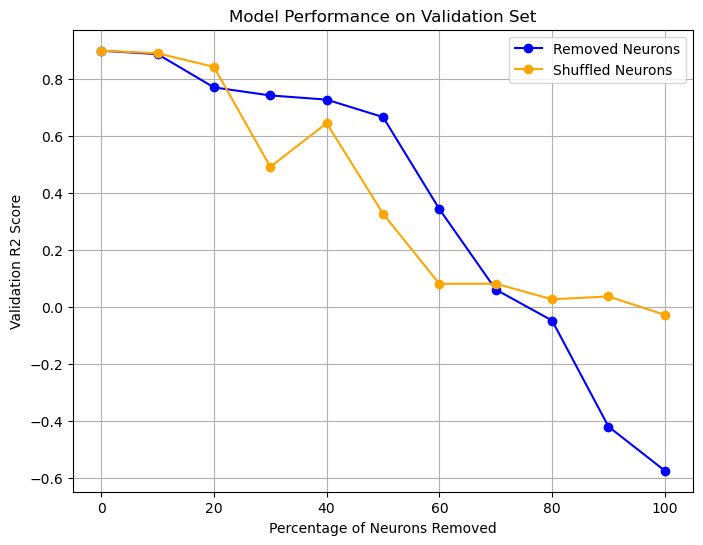

In [109]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(ratios, v_scores_removed, marker='o', color='b', linestyle='-', label = 'Removed Neurons')
plt.plot(ratios, v_scores_shuffled, marker='o', color='orange', linestyle='-', label = 'Shuffled Neurons')

# Add labels and title
plt.xlabel('Percentage of Neurons Removed')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()

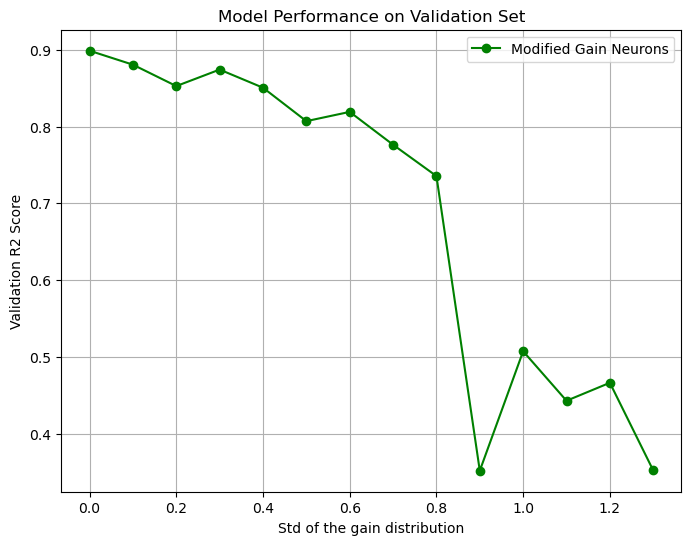

In [110]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(stds_gain, v_scores_gain, marker='o', color='g', linestyle='-', label = 'Modified Gain Neurons')

# Add labels and title
plt.xlabel('Std of the gain distribution')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()

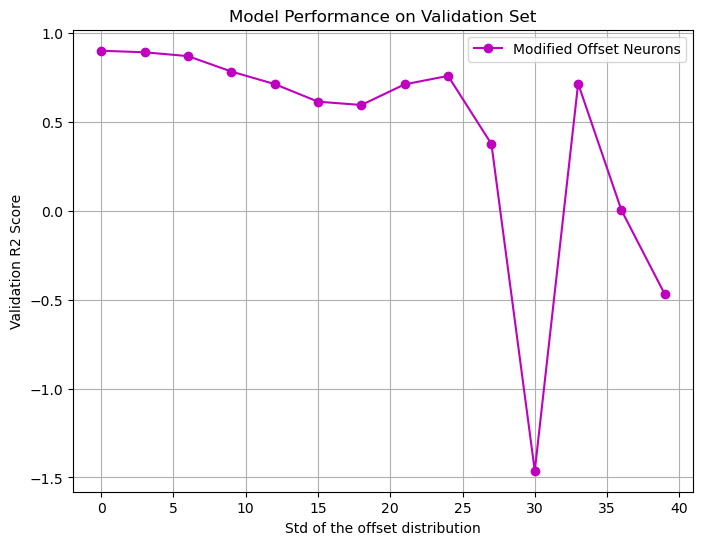

In [111]:
# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(stds_offset, v_scores_offset, marker='o', color='m', linestyle='-', label = 'Modified Offset Neurons')

# Add labels and title
plt.xlabel('Std of the offset distribution')
plt.ylabel('Validation R2 Score')
plt.title('Model Performance on Validation Set')
plt.legend()
# Add grid lines
plt.grid(True)

# Customize ticks and tick labels if needed
# plt.xticks(ratios)
# plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# Show plot
plt.show()